## Import Neccessary Libraries

In [139]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
from typing import Tuple, Dict, List
from torchinfo import summary


import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Setup device-agnostic code

In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Downloading Our Dataset

In [3]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

In [2]:
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

Did not find data\pizza_steak_sushi directory, creating one...


Unzip pizza, steak, sushi data

In [4]:
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(image_path)

Unzipping pizza, steak, sushi data...


In [11]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [12]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


## EDA

In [13]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


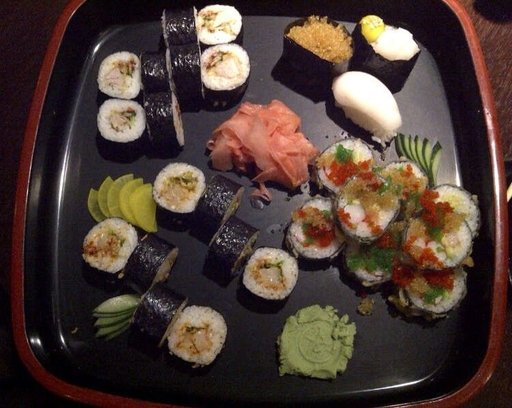

In [15]:
random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 407.5, -0.5)

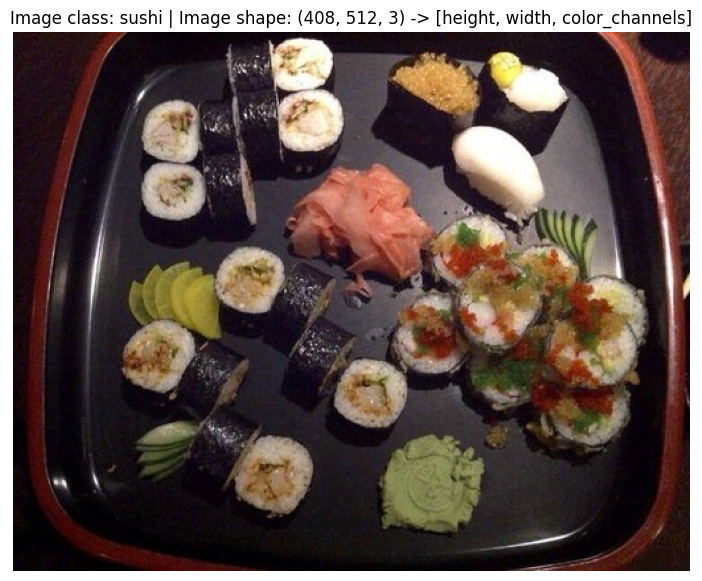

In [18]:
img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

## Data Preprocessing

In [40]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

tensors are [C,H,W] but matplotlib prefers [h,w,c]which is why we permute

In [41]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            print(fig, ax)

            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis('off')

            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            
            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

Figure(640x480) [<Axes: > <Axes: >]
Figure(640x480) [<Axes: > <Axes: >]
Figure(640x480) [<Axes: > <Axes: >]


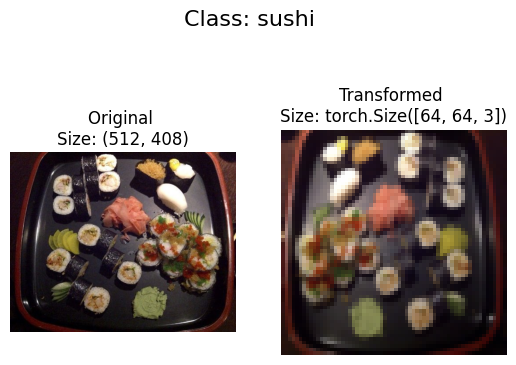

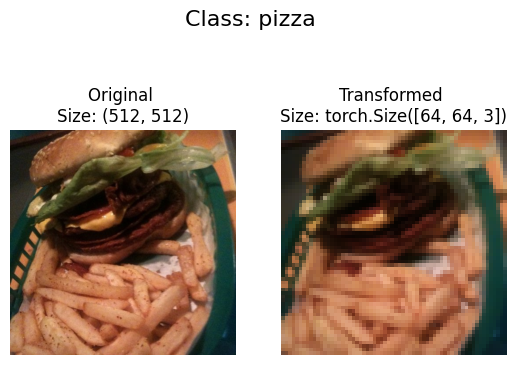

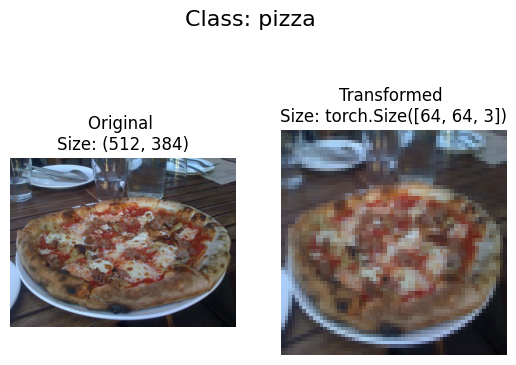

In [42]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [43]:
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

In [44]:
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [45]:
class_names = train_data.classes

In [46]:
class_names

['pizza', 'steak', 'sushi']

In [54]:
len(test_data), len(train_data)

(75, 225)

In [52]:
class_dict = train_data.class_to_idx

In [53]:
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [66]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

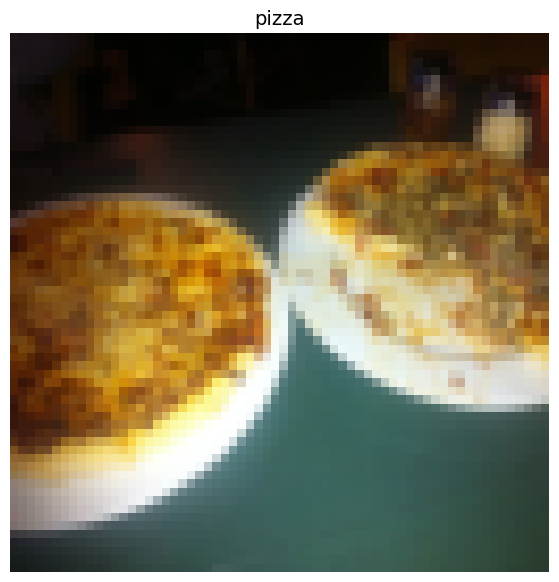

In [67]:
img_permute = img.permute(1,2,0)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(
    f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [68]:
train_dataloader = DataLoader(dataset=train_data, batch_size=1, num_workers=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=1, num_workers=1, shuffle=False)

In [69]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1a14a496ad0>,
 <torch.utils.data.dataloader.DataLoader at 0x1a14a4962f0>)

In [71]:
img, label = next(iter(train_dataloader))
f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]", f"Label shape: {label.shape}"

('Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]',
 'Label shape: torch.Size([1])')

### Customizing the Dataloader function

In [75]:
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted(
    [entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data\pizza_steak_sushi\train
Class names found: ['pizza', 'steak', 'sushi']


In [76]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(
        directory) if entry.is_dir())

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [77]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Custom Function to replicate ImageLoader()

In [78]:
class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
    
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # required for subclasses of torch.utils.data.Dataset
    def __len__(self) -> int:
        return len(self.paths)
    
    # required for subclasses of torch.utils.data.Dataset
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index)
        # expects path in data_folder/class_name/image.jpeg
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx  # return data, label (X, y)
        else:
            return img, class_idx

In [79]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [80]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x1a14a49c610>,
 <__main__.ImageFolderCustom at 0x1a14a49fa60>)

In [81]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [82]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [83]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [84]:
print((len(train_data_custom) == len(train_data))
      & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


All True, It works fine

In [85]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

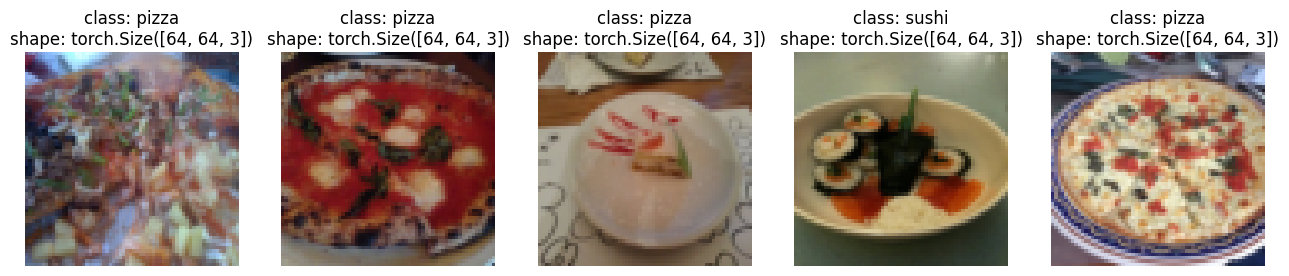

In [86]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

#### Custom Data function data

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


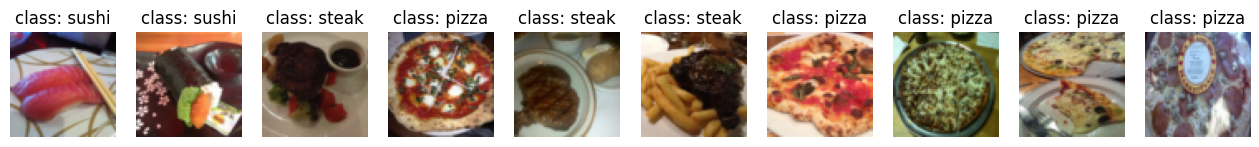

In [87]:
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

In [90]:
train_dataloader_custom = DataLoader(
    dataset=train_data_custom, batch_size=1, num_workers=0, shuffle=True)
test_dataloader_custom = DataLoader(
    dataset=test_data_custom, batch_size=1, num_workers=0, shuffle=False)

In [91]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1a14a5fee60>,
 <torch.utils.data.dataloader.DataLoader at 0x1a14a5fc9d0>)

In [92]:
img_custom, label_custom = next(iter(train_dataloader_custom))

print(
    f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## Data Augmentation

In [119]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

Figure(640x480) [<Axes: > <Axes: >]
Figure(640x480) [<Axes: > <Axes: >]
Figure(640x480) [<Axes: > <Axes: >]


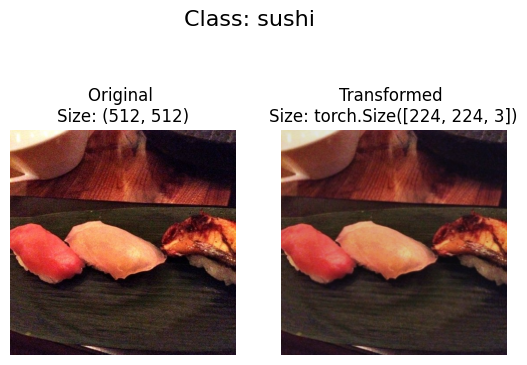

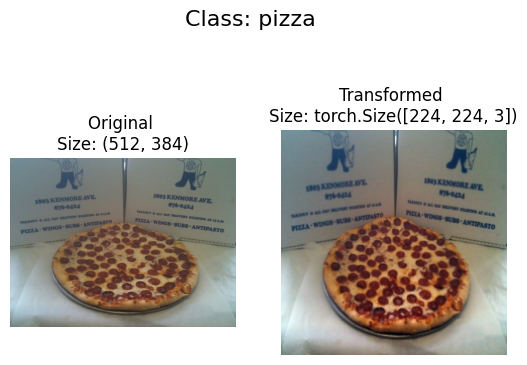

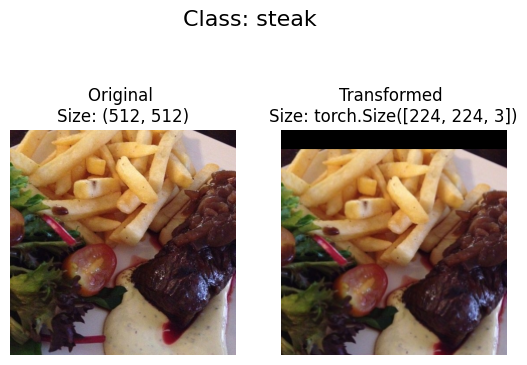

In [95]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [96]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

## Our Model

In [97]:
train_data_simple = datasets.ImageFolder(
    root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(
    root=test_dir, transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [98]:
print(
    f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 8 workers.


(<torch.utils.data.dataloader.DataLoader at 0x1a1465d0b80>,
 <torch.utils.data.dataloader.DataLoader at 0x1a1391b67d0>)

Forward pass uses Operator Fusion for x variable, no extra memory, only computation

In [106]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layers, out_channels=hidden_layers,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(hidden_layers, hidden_layers, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_layers, hidden_layers, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.classifier(x)
        return x

input shape is 3 becuaause we have 3 color channels

In [107]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_layers=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [108]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(
    f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


In [110]:
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

From the summary above, we can see that evey maxpool layer cuts our last 2 dims in half and also the in features of the Classifier Linear Layer is `hidden_layer*h/4*w/4`, /4 because it passes through 2 maxpoll2d with kernel2

## Training

In [111]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [112]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() /
                         len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [113]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(
            train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(
            train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(
            test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(
            test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [115]:
# Set random seeds
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,  # number of color channels (3 for RGB)
                  hidden_layers=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1435 | test_acc: 0.1979
Total training time: 119.257 seconds


In [117]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [116]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

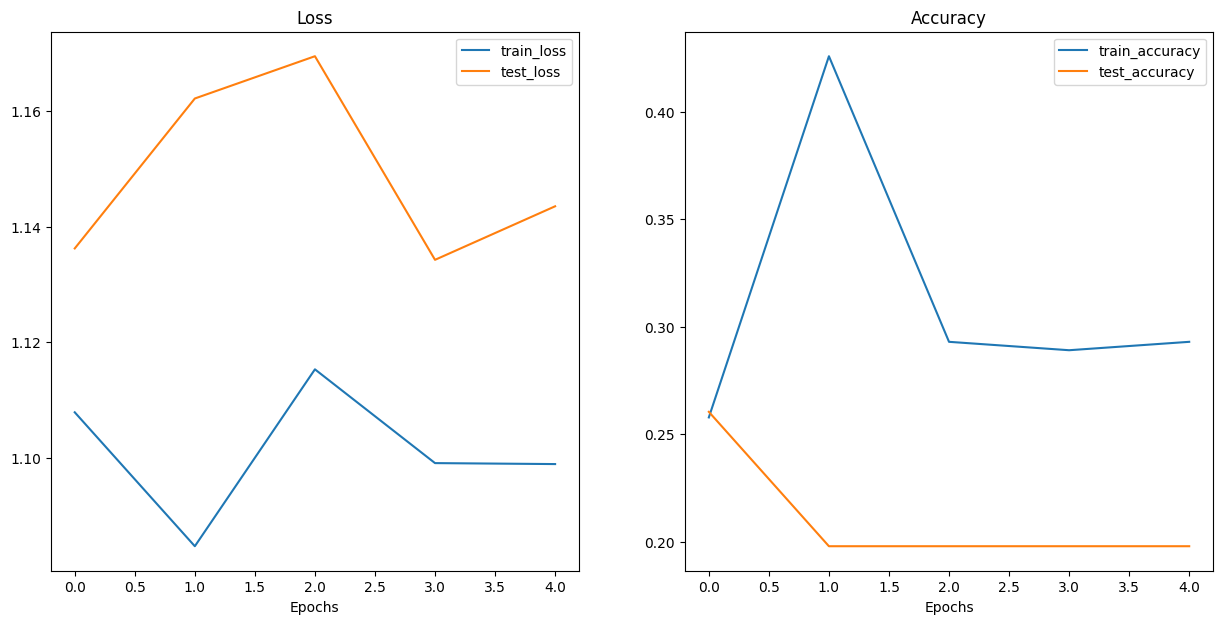

In [118]:
plot_loss_curves(model_0_results)

## Trying Data Augmentation to stop our Model from Underfitting/Overfitting

In [120]:
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [121]:
train_data_augmented = datasets.ImageFolder(
    train_dir, transform=train_transform_trivial_augment)

In [123]:
train_data_augmented

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

In [124]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1a152a07640>,
 <torch.utils.data.dataloader.DataLoader at 0x1a14a672710>)

In [127]:
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_layers=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [128]:
# Set random seeds
from timeit import default_timer as timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1385 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1620 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0884 | train_acc: 0.4258 | test_loss: 1.1479 | test_acc: 0.2604
Total training time: 152.442 seconds


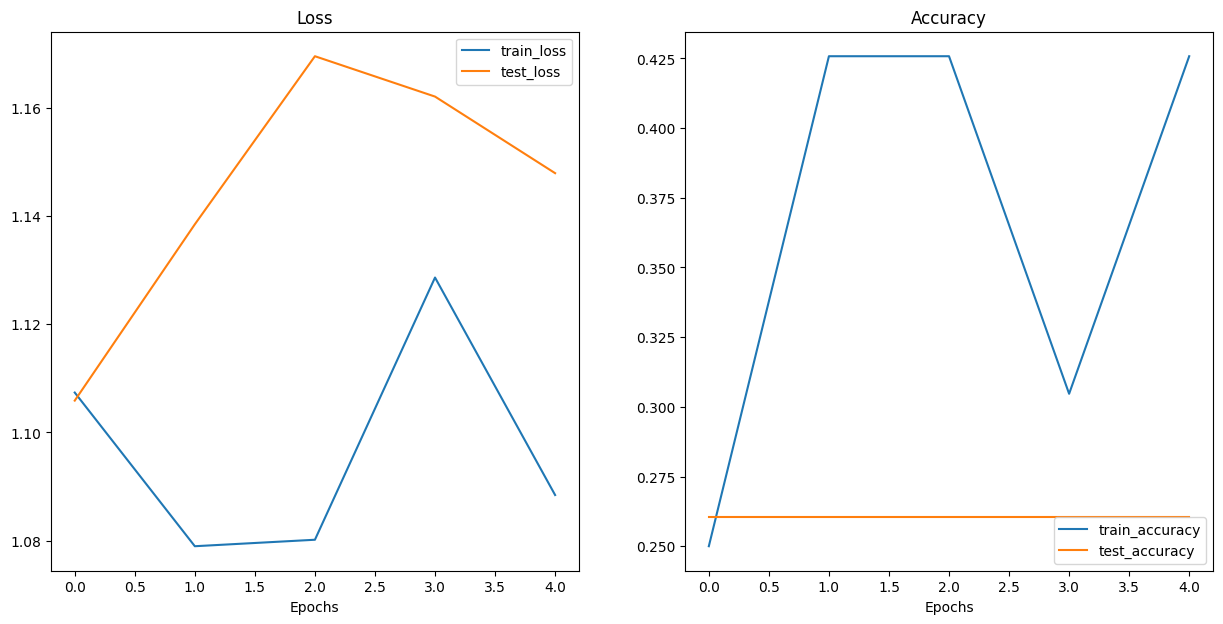

In [129]:
plot_loss_curves(model_1_results)

In [130]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084646,0.425781,1.162170,0.197917
2,1.115275,0.292969,1.169490,0.197917
3,1.099037,0.289062,1.134237,0.197917
4,1.098870,0.292969,1.143505,0.197917


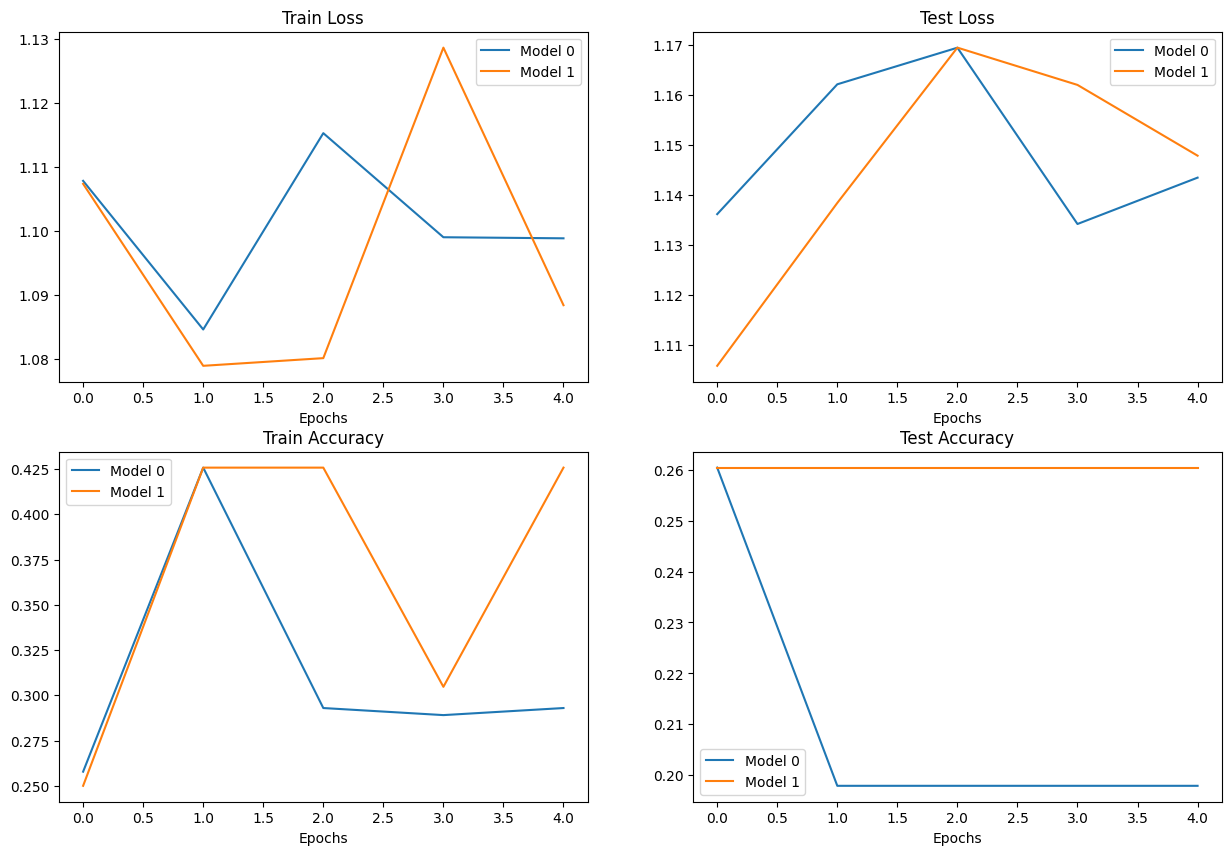

In [132]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

## Predicting with our Models

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get(
            "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [142]:
custom_image_path = data_path / "04-pizza-dad.jpeg"

In [143]:
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

We have to preprocess this custom test image before we can pass it on to our model

In [144]:
# Load in custom image and convert the tensor values to float32
custom_image = custom_image_uint8.type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

(-0.5, 3023.5, 4031.5, -0.5)

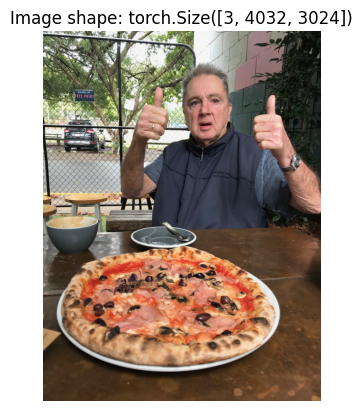

In [145]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [146]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image).to(device)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [153]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0))

In [161]:
torch.softmax(custom_image_pred, dim=1).argmax(dim=1)

tensor([0], device='cuda:0')

In [162]:
class_names[torch.softmax(custom_image_pred, dim=1).argmax(dim=1).item()]

'pizza'